In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
#s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

#config=tf.ConfigProto(gpu_options=gpu_options)

from tensorflow import keras

from keras.models import Model, load_model

#from tensorflow import keras
#K = keras.backend

##from tensorflow import keras
K = keras.backend
import keras, keras.layers as L
#from keras import layers as L
#from keras.models import Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout, BatchNormalization, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose

from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dropout, ZeroPadding2D
from keras.layers.merge import concatenate

from keras.layers.merge import concatenate
from keras.layers import Activation, Dense, Cropping2D
from keras.layers import LeakyReLU, Flatten, UpSampling2D, Deconv2D
from keras.models import Model

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras import backend as kbackend 



#keras.backendckend.backend()
#from tensorflow import keras
#import keras.backend.tensorflow_backend as K

#K.set_session

Using TensorFlow backend.


In [2]:
path = "home/hampus/kaggle/tgssalt"
DIR = 'home/hampus/kaggle/tgssalt'
path_train = "home/hampus/kaggle/tgssalt/train"
path_test = 'home/hampus/kaggle/tgssalt/test'
imgs_train = 'train/images'
masks_train = 'train/masks'
imgs_test = 'home/hampus/kaggle/tgssalt/test/images'

IMG_SIZE = 101   # original/raw image size
TGT_SIZE = 128   # model/input image size
DPT_SIZE = 4     # CONV filter size when depth is input in model
MAX_DEPTH = None # maximum depth('z') of seismic image, set after loading data

In [3]:
train_df = pd.read_csv('train.csv', index_col="id", usecols=[0])
depths_df = pd.read_csv('depths.csv', index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]


In [4]:
train_df["images"] = [np.array(load_img('train/images/%s.png' % idx, grayscale=True)) / 255 
                      for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img('train/masks/%s.png' % idx, grayscale=True)) / 255 
                     for idx in tqdm_notebook(train_df.index)]

In [6]:
MAX_DEPTH = max(train_df["z"])
train_df["depth"] = [np.ones_like(train_df.loc[i]["images"]) * train_df.loc[i]["z"] / MAX_DEPTH
                     for i in tqdm_notebook(train_df.index)]
train_df["depth"][0].shape

(101, 101)

In [7]:
train_df.shape

(4000, 4)

In [8]:
train_df.head()

,z,images,masks,depth
id,,,,
575d24d81d,843,"[[0.525490196078, 0.513725490196, 0.5254901960...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.879040667362, 0.879040667362, 0.8790406673..."
a266a2a9df,794,"[[0.341176470588, 0.376470588235, 0.3333333333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.827945776851, 0.827945776851, 0.8279457768..."
75efad62c1,468,"[[0.56862745098, 0.466666666667, 0.32549019607...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.488008342023, 0.488008342023, 0.4880083420..."
34e51dba6a,727,"[[0.541176470588, 0.474509803922, 0.3960784313...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.758081334724, 0.758081334724, 0.7580813347..."
4875705fb0,797,"[[0.0666666666667, 0.078431372549, 0.090196078...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.831074035454, 0.831074035454, 0.8310740354..."


In [9]:
def coverage(mask):
    """Compute coverage of salt mask """
    return np.sum(mask) / (mask.shape[0]*mask.shape[1])

In [10]:
def coverage_class(mask):
    """Compute class coverage of salt mask """
    if coverage(mask) == 0:
        return 0
    return (coverage(mask) * 100 //10).astype(np.int8) +1

In [11]:
def mem_used():
    """Memory used"""
    import resource
    return round(resource.getrusage(resource.RUSAGE_SELF)[2] * 10/1028 / 10, 1)

In [12]:
mem_used()


1239.2

In [13]:
def mem_fun(fun, **kwargs):
    """"""
    mem_start = mem_used()
    _ = fun(**kwargs)
    print('memory used by function: {}mb'.format((mem_used() - mem_start)))

nb_mem = mem_used()

In [14]:
#IMG_SIZE = 101   # original/raw image size
#TGT_SIZE = 128   # model/input image size

def upsample(img):
    if IMG_SIZE == TGT_SIZE:
        return img
    return resize(img, (TGT_SIZE, TGT_SIZE), mode='constant', preserve_range=True)


def downsample(img):
    if IMG_SIZE == TGT_SIZE:
        return img
    return resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)



In [15]:
mem_used()

1239.2

In [16]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(IMG_SIZE, 2)

In [17]:
def covrage_to_class(val):    
    for i in range(11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(covrage_to_class)

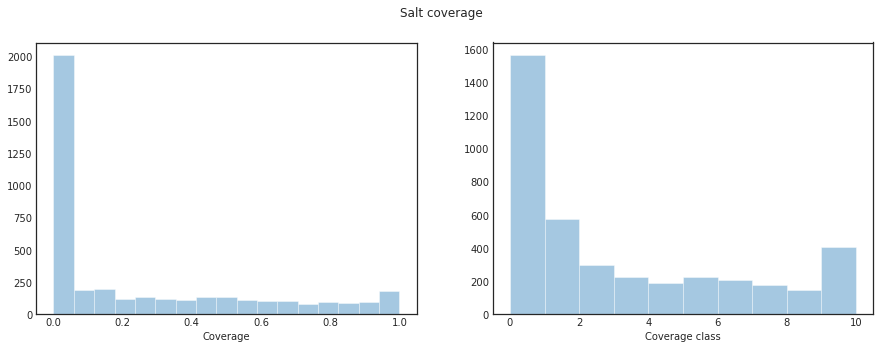

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [41]:
mem_used()


1248.4

In [39]:
train_df['images'].shape[0]
train_df['depth'].shape[0]
print(train_df['z'][2])
train_df['d'] = train_df.depth.map(np.max)
train_df['d'] = np.round(train_df['d'],decimals=3)
print(train_df['d'][-2])

468
0.23


In [20]:
def shuffle(matrix, target, testproc):
    ratio = matrix.shape[0]/test_proportion
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(X, Y, 3)

In [40]:
mem_used()

1248.4

In [52]:
x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    
    #np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.images.tolist()).reshape(-1,IMG_SIZE,IMG_SIZE,1),
    #np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
     np.array(train_df.masks.tolist()).reshape(-1,IMG_SIZE,IMG_SIZE,1),
    train_df.coverage.values,
    train_df.d.values,
    test_size=0.15, stratify=train_df.coverage_class, random_state=42)

In [22]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    #ses = K.get_session()
    #return ses
reset_tf_session()
#s= tf.Session()
#K.set_session
keras.backend.set_session

<function keras.backend.tensorflow_backend.set_session(session)>

In [47]:

inputs1 = Input((IMG_SIZE,IMG_SIZE,1))

#First conv layer
zeros1 = ZeroPadding2D(padding=((1,0),(1,0)))(inputs1)
conv11 = Conv2D(32,kernel_size=(3, 3), strides =(1,1), activation="relu", padding="same")(zeros1)
drop1 = Dropout(0.2)(conv11)
conv12 = Conv2D(32,kernel_size=(3, 3), strides =(1,1), activation="relu", padding="same")(drop1)
batch1 = BatchNormalization()(conv12)
conv1 = Conv2D(32,kernel_size=(3, 3), strides =(2,2),activation="relu",padding="same",name="conv1")(batch1)

#Second conv layer
zeros2 = ZeroPadding2D(padding=((1,0),(1,0)))(conv1)
conv21 = Conv2D(64, kernel_size = (3,3), strides = ( 1,1), activation="relu", padding="same")(zeros2)
drop2 = Dropout(0.3)(conv21)
conv22 = Conv2D(64, kernel_size=(3,3), strides = (1,1), activation= "relu", padding = "same")(drop2)
batch2 = BatchNormalization()(conv22)
conv2 = Conv2D(64, kernel_size=(3,3), strides = (2,2), activation = "relu", padding = "same",name="conv2")(batch2)


#third conv layer
#zeros3 = ZeroPadding2D(padding=((1,0),(1,0)))(conv2)
conv31 = Conv2D(128, kernel_size = (3,3), strides = ( 1,1), activation="relu", padding="same")(conv2)
drop3 = Dropout(0.3)(conv31)
conv32 = Conv2D(128, kernel_size=(3,3), strides = (1,1), activation= "relu", padding = "same")(drop3)
batch3 = BatchNormalization()(conv32)
conv3 = Conv2D(128, kernel_size=(3,3), strides = (2,2), activation = "relu", padding = "same",name="conv3")(batch3)


#third conv layer
zeros4 = ZeroPadding2D(padding=((1,0),(1,0)))(conv3)
conv4 = Conv2D(256, kernel_size = (3,3), strides = ( 1,1), activation="relu", padding="same")(zeros4)
drop4 = Dropout(0.5)(conv4)
conv4 = Conv2D(256, kernel_size=(3,3), strides = (1,1), activation= "relu", padding = "same")(drop4)
batch4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, kernel_size=(3,3), strides = (1,1), activation = "relu", padding = "same",name="conv4")(batch4)


#first upconv layer
#up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(concatenate([Cropping2D(cropping=((1, 0), (1, 0)))(conv4), conv3], axis=3))
up5 = Cropping2D(cropping=((1, 1), (1, 1)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4))
con5 = concatenate([up5 , conv32], axis=3)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
#26x26

#second upconv layer Cropping2D(cropping=((1, 1), (1, 1)))
#up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv22], axis=3)
#Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(concatenate([(conv5), conv2], axis=3))
#conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
#conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

up6 = (Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5))
con6 = concatenate([up6 , batch2], axis=3)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(con6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
#52x52


#third upconv layer
up7 = (Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(Cropping2D(cropping=((1, 0), (1, 0)))(conv6)))
con7 = concatenate([up7 , batch1], axis=3)
crop7 = Cropping2D(cropping=((1, 0), (1, 0)))(con7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(crop7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)


output = Conv2D(1,kernel_size = (1,1),activation = 'sigmoid')(conv7)

Unetmodel = Model(inputs = [inputs1],outputs =output)
print(Unetmodel.summary())

Unetmodel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 101, 101, 1)   0                                            
____________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D) (None, 102, 102, 1)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 102, 102, 32)  320         zero_padding2d_4[0][0]           
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 102, 102, 32)  0           conv2d_16[0][0]                  
___________________________________________________________________________________________

In [53]:
mem_used()

3126.6

In [54]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=6, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = Unetmodel.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3400 samples, validate on 600 samples
Epoch 1/200
3400/3400 [==============================] - 35s - loss: 0.4415 - acc: 0.7947 - val_loss: 5.5819 - val_acc: 0.2494
Epoch 2/200
3400/3400 [==============================] - 27s - loss: 0.3297 - acc: 0.8750 - val_loss: 2.7364 - val_acc: 0.2494
Epoch 3/200
3400/3400 [==============================] - 25s - loss: 0.3064 - acc: 0.8876 - val_loss: 2.1868 - val_acc: 0.2659
Epoch 4/200
3400/3400 [==============================] - 24s - loss: 0.2755 - acc: 0.8990 - val_loss: 4.0998 - val_acc: 0.3480
Epoch 5/200
3400/3400 [==============================] - 25s - loss: 0.2529 - acc: 0.9053 - val_loss: 0.3718 - val_acc: 0.8331
Epoch 6/200
3400/3400 [==============================] - 25s - loss: 0.2446 - acc: 0.9109 - val_loss: 0.2908 - val_acc: 0.8852
Epoch 7/200
3400/3400 [==============================] - 25s - loss: 0.2445 - acc: 0.9109 - val_loss: 0.2619 - val_acc: 0.9008
Epoch 8/200
3400/3400 [==============================] - 24s - l

In [55]:
mem_used()

3358.7

In [56]:
def mean_iou(Y_true, Y_pred, score_thres=0.5):
    """Compute mean(IoU) metric
    IoU = intersection / union
    
    For each (mask)threshold in provided range:
     - convert probability mask to boolean mask based on given threshold
     - score the mask 1 if(IoU > score_threshold(0.5))
    Take the mean of the scoress

    https://www.tensorflow.org/api_docs/python/tf/metrics/mean_iou
    """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        Y_pred_bool = tf.to_int32(Y_pred > t) # boolean mask by threshold
        score, update_op = tf.metrics.mean_iou(Y_true, Y_pred_bool, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            score = tf.identity(score) #!! use identity to transform score to tensor
        prec.append(score) 
        
    return K.mean(K.stack(prec), axis=0)
